# TESTS

In [1]:
from pathlib import Path
import os
import modflowapi
from modflowapi import Callbacks
from workflow import *
from datetime import datetime

DT_FMT = "%Y-%m-%d %H:%M:%S"


In [ ]:
sim = build_model(ws = 'model', sim_name = 'engesgaard1992', spls = ['sodium'])


In [ ]:
# sim_ws = os.path.join('model', '1dtest', 'chloride')
sim_ws = Path("model/engesgaard1992/")
dll = Path("bin/win/libmf6")

In [ ]:
def try_get_value(address, mf6):
    try:
        res = mf6.get_value(address)
        return res
    except:
        res = 'failed'
        return res

In [ ]:
mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()
# current_time = mf6.get_current_time()
# end_time = mf6.get_end_time()
all_vars = mf6.get_input_var_names() 

# var_add = 

# try:
#     mf6.finalize()
#     success=True
# except:
#     raise RuntimeError

In [ ]:
# current_time, end_time

# all_vars
df_vars = pd.DataFrame(all_vars)[0].str.split('/', expand=True)
df_vars['addr'] = all_vars
df_vars.to_csv('vars.csv')

In [ ]:
val = mf6.get_value(mf6.get_var_address("x", 'SODIUM'))
val += 1

# val = val + 1
val += 1
# mf6.get_value(mf6.get_var_address("x", 'SODIUM')) = val

In [ ]:
mf6.finalize()
val

In [ ]:

mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()

sim_start = datetime.now()
print("...starting transport solution at {0}".format(sim_start.strftime(DT_FMT)))
# reset the node tracking containers

# get the current sim time
ctime = mf6.get_current_time()
ctimes = [0.0]
# get the ending sim time
etime = mf6.get_end_time()
# max number of solution iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_1"))
num_fails = 0
# let's do it!
while ctime < etime:
    sol_start = datetime.now()
    # length of the current solve time
    dt = mf6.get_time_step()
    # prep the current time step
    mf6.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    mf6.prepare_solve(1)
    # the one-based stress period number
    stress_period = mf6.get_value(mf6.get_var_address("KPER", "TDIS"))[0]
    time_step = mf6.get_value(mf6.get_var_address("KSTP", "TDIS"))[0]

    # solve until converged
    while kiter < max_iter:
        # apply whatever change we want here
        # val = mf6.get_value(mf6.get_var_address("x", 'SODIUM'))
        # val += 1
        convg = mf6.solve(1)
        if convg:
            td = (datetime.now() - sol_start).total_seconds() / 60.0
            print("transport stress period,time step {0},{1} converged with {2} iters, took {3:10.5G} mins".format(stress_period, time_step, kiter,td))
            break
        kiter += 1

    if not convg:
        td = (datetime.now() - sol_start).total_seconds() / 60.0
        print("transport stress period,time step {0},{1} did not converged, {2} iters, took {3:10.5G} mins".format(
            stress_period, time_step, kiter, td))
        num_fails += 1
mf6.finalize()


In [ ]:
def callback_function(sim, callback_step):
    """
    A demonstration function that dynamically adjusts recharge
    and pumping in a modflow-6 model through the MODFLOW-API

    Parameters
    ----------
    sim : modflowapi.ApiSimulation
        A simulation object for the solution group that is
        currently being solved
    step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution modflow is currently in.
    """
    ml = sim.get_model()
    if callback_step == Callbacks.initialize:
        print(sim.models)

    # if callback_step == Callbacks.stress_period_start:
    #     # adjust recharge for stress periods 7 through 12
    #     if sim.kper <= 6:
    #         rcha = ml.rcha_0
    #         spd = rcha.stress_period_data
    #         print(f"updating recharge: stress_period={ml.kper}")
    #         spd["recharge"] += 0.40 * sim.kper

    if callback_step == Callbacks.timestep_start:
        print(
            f"Testing: stress_period={ml.kper}, timestep={ml.kstp}", ml.kstp
        )
        if ml.kstp != 2:
            ml.wel.stress_period_data["q"] *= 1/ml.kstp
            # ml.wel.stress_period_data['CONCENTRATION'] = 100000000
            # print('..........................', ml.wel.stress_period_data['CONCENTRATION'])
        else:
            ml.wel.stress_period_data['q'] = 0
        # if ml.kstp ==2:
            
    if callback_step == Callbacks.iteration_start:
        # we can implement complex solutions to boundary conditions here!
        pass
    # return wel

# modflowapi.run_simulation(dll, sim_ws, callback_function, verbose=True)


In [ ]:
ucn = flopy.utils.HeadFile(os.path.join("model",'engesgaard1992',"sodium.ucn"),text="concentration")
carr = ucn.get_alldata()

In [ ]:
# carr[0][0]
carr[-1,0,0,:]

# PHREEQCRM TEST

In [1]:
import phreeqcrm
import numpy as np
import os
import sys

In [2]:
nxyz = 20
nthreads = 1
phreeqc_rm = phreeqcrm.PhreeqcRM(nxyz, nthreads)

In [3]:
status = phreeqc_rm.SetComponentH2O(False)
phreeqc_rm.UseSolutionDensityVolume(False)
status = phreeqc_rm.SetFilePrefix("SimpleAdvect_py")
phreeqc_rm.OpenFiles()
poro = np.full((nxyz), 0.2)
status = phreeqc_rm.SetPorosity(poro)

In [4]:
print_chemistry_mask = np.full((nxyz), 1)
status = phreeqc_rm.SetPrintChemistryMask(print_chemistry_mask)
nchem = phreeqc_rm.GetChemistryCellCount()

In [5]:
# Load database
databasews = os.path.join("database", "phreeqc.dat")
status = phreeqc_rm.LoadDatabase(databasews)
status = phreeqc_rm.RunFile(True, True, True, "advect.pqi")
# Clear contents of workers and utility
input = "DELETE; -all"
status = phreeqc_rm.RunString(True, False, True, input)

ncomps = phreeqc_rm.FindComponents()
ncomps

components = phreeqc_rm.GetComponents()
components

for comp in components:
    phreeqc_rm.OutputMessage(comp)
phreeqc_rm.OutputMessage("\n")

ic1 = [-1] * nxyz * 7 
ic1
for i in range(nxyz):
    ic1[i]            =  1  # Solution 1
    ic1[nxyz + i]     = -1  # Equilibrium phases none
    ic1[2 * nxyz + i] =  1  # Exchange 1
    ic1[3 * nxyz + i] = -1  # Surface none
    ic1[4 * nxyz + i] = -1  # Gas phase none
    ic1[5 * nxyz + i] = -1  # Solid solutions none
    ic1[6 * nxyz + i] = -1  # Kinetics none

status = phreeqc_rm.InitialPhreeqc2Module(ic1)

# Initial equilibration of cells
time = 0.0
time_step = 0.0
status = phreeqc_rm.SetTime(time)
status = phreeqc_rm.SetTimeStep(time_step)
status = phreeqc_rm.RunCells()


In [6]:
status
c_dbl_vect = phreeqc_rm.GetConcentrations()

In [7]:
c_dbl_vect

array([ 1.11564766e+05,  1.11564766e+05,  1.11564766e+05,  1.11564766e+05,
        1.11564766e+05,  1.11564766e+05,  1.11564766e+05,  1.11564766e+05,
        1.11564766e+05,  1.11564766e+05,  1.11564766e+05,  1.11564766e+05,
        1.11564766e+05,  1.11564766e+05,  1.11564766e+05,  1.11564766e+05,
        1.11564766e+05,  1.11564766e+05,  1.11564766e+05,  1.11564766e+05,
        8.85500618e+05,  8.85500618e+05,  8.85500618e+05,  8.85500618e+05,
        8.85500618e+05,  8.85500618e+05,  8.85500618e+05,  8.85500618e+05,
        8.85500618e+05,  8.85500618e+05,  8.85500618e+05,  8.85500618e+05,
        8.85500618e+05,  8.85500618e+05,  8.85500618e+05,  8.85500618e+05,
        8.85500618e+05,  8.85500618e+05,  8.85500618e+05,  8.85500618e+05,
       -3.38515228e-13, -3.38515228e-13, -3.38515228e-13, -3.38515228e-13,
       -3.38515228e-13, -3.38515228e-13, -3.38515228e-13, -3.38515228e-13,
       -3.38515228e-13, -3.38515228e-13, -3.38515228e-13, -3.38515228e-13,
       -3.38515228e-13, -

# Engesgaard 1992 - PHT3D

In [51]:
wd = os.path.join('benchmark', 'pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)
# simdf.columns = [col.lower() for col in simdf.columns]
simdf.loc[:, 'x'] = simdf['cell'] * dx 
simdf.head()


,cell,pH,pe,Ca,Cl,C4,Mg,Calcite,Dolomite,x
time_d,,,,,,,,,,
0.01,1.0,9.7017,-6.5533,0.000131,0.001121,0.0,0.000515,0.000000,0.000045,0.01
0.01,2.0,9.8379,-6.7482,0.000165,0.000373,0.0,0.000130,0.000000,0.000057,0.02
0.01,3.0,9.9058,-6.8288,0.000125,0.000092,0.0,0.000046,0.000115,0.000000,0.03
0.01,4.0,9.9087,-6.8347,0.000123,0.000024,0.0,0.000012,0.000120,0.000000,0.04
0.01,5.0,9.9095,-6.8362,0.000123,0.000007,0.0,0.000003,0.000122,0.000000,0.05


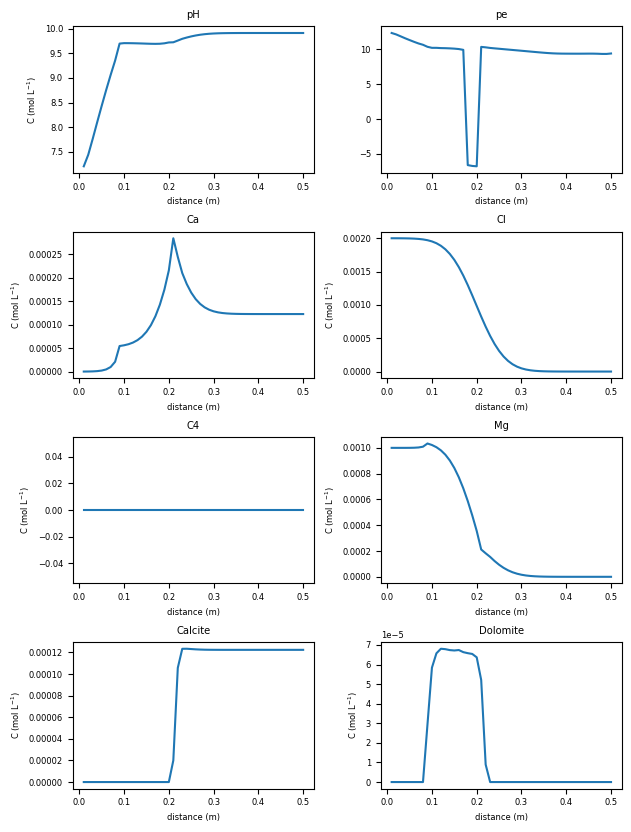

In [54]:
fig, axs = plt.subplots(4,2, figsize = (6.3, 8.3))
t = 0.24
for var, ax in zip(simdf.iloc[:,1:-1 ].columns, axs.flatten()):
    ax.plot(simdf.x.unique(), simdf.loc[t, var])
    ax.set_xlabel('distance (m)')
    if var not in ['ph', 'pe']:
        ax.set_ylabel('C (mol L$^{-1}$)')
    ax.set_title(f'{var}')

fig.tight_layout()

<Axes: xlabel='x'>

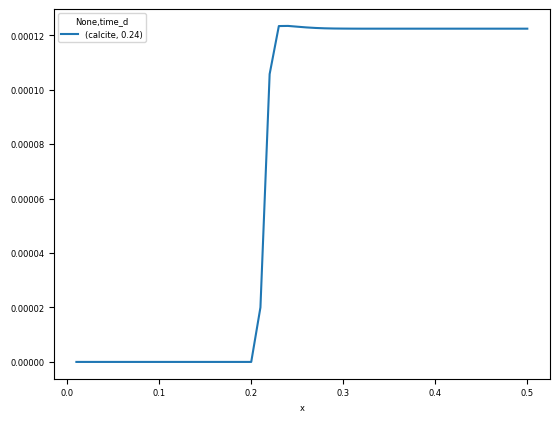

In [26]:
simdf.loc[0.24, ['x','calcite']].pivot_table(index='x', columns = 'time_d').plot() 

<Axes: xlabel='x'>

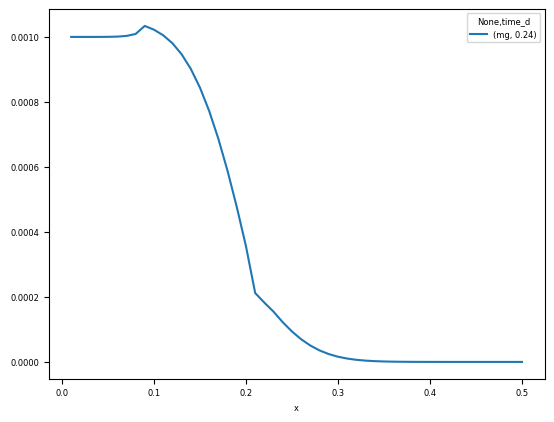

In [27]:
simdf.loc[0.24, ['x','mg']].pivot_table(index='x', columns = 'time_d').plot() 